In [43]:
import pandas as pd 
import numpy as np
import joblib
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
def train_test_split(data_dir, dataset_name, test_fraction, dev_fraction=None, seed=42):
    dev_ids, test_ids = [], []
    data: dict = joblib.load(f"{data_dir}/{dataset_name}_data_raw.pkl")
    print("Loaded", len(data), "examples.")

    # Select the indices for the holdout set
    rand = np.random.default_rng(seed)
    ids = np.arange(len(data))
    rand.shuffle(ids)
    
    assert 0 < test_fraction <= 1, f"Invalid test_fraction: {test_fraction}"
    test_num = round(test_fraction * len(data))
    
    test_ids = ids[:test_num]    
    print("Collecting", len(test_ids), "examples for the holdout set.")
    
    if dev_fraction is not None:
        assert 0 < dev_fraction <= 1, f"Invalid dev_fraction: {dev_fraction}"
        dev_num = round(dev_fraction * len(data))
    
        dev_ids = ids[test_num:test_num+dev_num]    
        print("Collecting", len(dev_ids), "examples for the dev set.")
    
    train_docs = data
    test_docs = {}
    dev_docs = {}
    
    data_ids = list(data.keys())

    for test_doc_id in test_ids:
        data_id = data_ids[test_doc_id] 
        test_docs[test_doc_id] = train_docs.pop(data_id)
    
    for dev_doc_id in dev_ids:
        data_id = data_ids[dev_doc_id] 
        dev_docs[dev_doc_id] = train_docs.pop(data_id)
        
    print("Dataset", dataset_name, "train-dev-test split:", len(train_docs), len(dev_docs), len(test_docs))
    return train_docs, dev_docs, test_docs


def flatten(dataset: dict) -> list:
    """
    {
        "doc_id": {
            "src": "This is the source text.",
            "ref_summ": "This is the reference summary",
            "sys_summs": {
                "sys_name1": {
                    "sys_summ": "This is the system summary.",
                    "scores": {
                        "human_metric1": 0.3,
                        "human_metric2": 0.5
    }}}}}
    """
    flattened = []
    
    for doc_id, doc_data in dataset.items():
        for sys_name, sys_data in doc_data["sys_summs"].items():
            data = {
                "bartscore_doc_id": doc_id,
                "src": doc_data["src"],
                "ref_summ": doc_data["ref_summ"],
                "sys_name": sys_name,
                "sys_summ": sys_data["sys_summ"],
            }
            
            data.update({f"sys_score_{col}": score for col, score in sys_data["scores"].items()})
            flattened.append(data)
    return flattened


def plot_distributions(data: list, labels: list, figsize=(10, 4), **kwargs):
    n = len(data)
    fig, axes = plt.subplots(1, n, sharex=True, sharey=True, tight_layout=True, figsize=figsize)

    hist_kwargs = {"bins": 10}
    hist_kwargs.update(**kwargs)
    
    for i, (datum, label) in enumerate(zip(data, labels)):
        sns.histplot(ax=axes[i], data=datum, **hist_kwargs)
        axes[i].set_title(label)
    plt.show()
    
    
def get_distribution(data, binrange, bins):
    out, bins = pd.cut(binrange, bins, retbins=True)
    
    intervals = pd.cut(data, bins=bins)
    return pd.DataFrame(intervals.value_counts() / len(data)).sort_index().reset_index()


def discretize_dist(data, col, binrange, bins):
    data = data.copy()

    out, bins = pd.cut(binrange, bins=bins, retbins=True) 
    intervals = pd.cut(data[col], bins=bins)
    data["bin"] = intervals
    data["label"] = intervals.cat.codes
    
    return data

## REAL Summarization

In [66]:
realsumm_metadata = {
    "dataset_name": "REALSumm",
    "col": "litepyramid_recall",
    "dev_fraction": 0.30,
    "test_fraction": 0.30,
    "seed": 498151,
    "raw_dataset_dir": "./data/summarization",
    "output_dir": "./data/summarization/REALSumm",
}

Loaded 100 examples.
Dataset REALSumm train-dev-test split: 40 30 30
Train, dev, test set `sys_score_litepyramid_recall` distribution


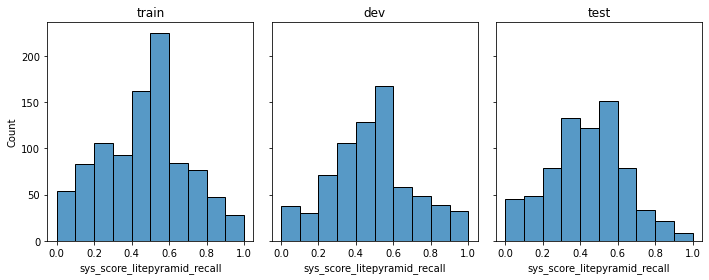

--------------------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
--------------------------------------------------------------------------------


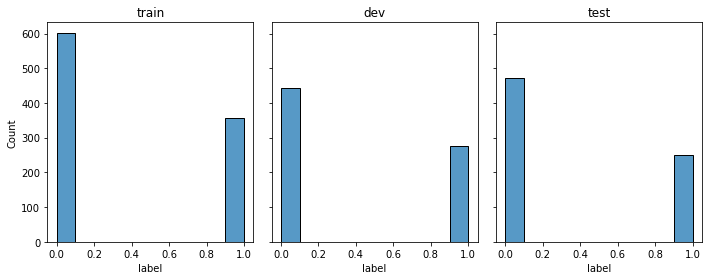

train
           index  sys_score_litepyramid_recall
0  (-0.001, 0.5]                      0.627083
1     (0.5, 1.0]                      0.372917
dev
           index  sys_score_litepyramid_recall
0  (-0.001, 0.5]                      0.616667
1     (0.5, 1.0]                      0.383333
test
           index  sys_score_litepyramid_recall
0  (-0.001, 0.5]                      0.654167
1     (0.5, 1.0]                      0.345833
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


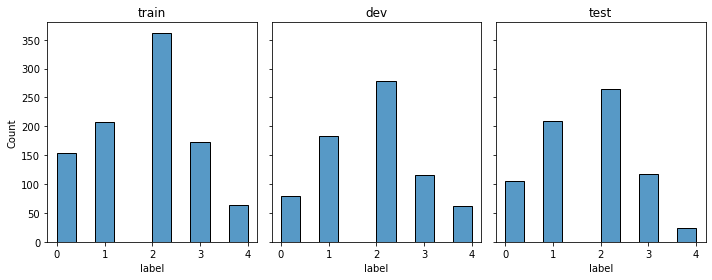

train
           index  sys_score_litepyramid_recall
0  (-0.001, 0.2]                      0.159375
1     (0.2, 0.4]                      0.216667
2     (0.4, 0.6]                      0.377083
3     (0.6, 0.8]                      0.180208
4     (0.8, 1.0]                      0.066667
dev
           index  sys_score_litepyramid_recall
0  (-0.001, 0.2]                      0.111111
1     (0.2, 0.4]                      0.254167
2     (0.4, 0.6]                      0.387500
3     (0.6, 0.8]                      0.161111
4     (0.8, 1.0]                      0.086111
test
           index  sys_score_litepyramid_recall
0  (-0.001, 0.2]                      0.145833
1     (0.2, 0.4]                      0.290278
2     (0.4, 0.6]                      0.368056
3     (0.6, 0.8]                      0.162500
4     (0.8, 1.0]                      0.033333


In [129]:
def create_dataset(dataset_name, col, dev_fraction, test_fraction, seed, raw_dataset_dir, output_dir, scale=None):
    col = f"sys_score_{col}"
    os.makedirs(output_dir, exist_ok=True)
    
    # ------------------------------------------------------
    # Step 1. Create the splits
    # ------------------------------------------------------
    # Train test split
    data = train_test_split(raw_dataset_dir, dataset_name, test_fraction, dev_fraction, seed)

    # Flatten the nested dictionary
    data = [flatten(d) for d in data]

    # Transform into dataframe to be more manageable and visual
    dfs = [pd.DataFrame(d).reset_index() for d in data]
    dfs_names = ["train", "dev", "test"]
    
    # ------------------------------------------------------
    # Step 2. Plot distributions
    # ------------------------------------------------------
    print("=" * 80)
    print(f"Train, dev, test set `{col}` distribution")
    plot_distributions(data=[d[col] for d in dfs], labels=dfs_names)
    
    if scale is not None:
        print("Scale!")
        def min_max_scale(df, min_r, max_r):
            df[col] = df[col].apply(lambda e: (e-min_r)/(max_r-min_r))
            return df
        
        dfs = [min_max_scale(df, *scale) for df in dfs]
        plot_distributions(data=[d[col] for d in dfs], labels=dfs_names)

    
    # Step 2.1. Plot *binary* distribution
    print("-" * 80)
    binary_configs = {"binrange": (0, 1), "bins": 2}
    print("2-class distribution using configs:", binary_configs)
    print("-" * 80)

    dfs_class2 = [discretize_dist(d, col, **binary_configs) for d in dfs]
    plot_distributions(data=[d["label"] for d in dfs_class2], labels=dfs_names)

    for d, d_name in zip(dfs_class2, dfs_names):
        if len(d) != 0:
            print(d_name)
            print(get_distribution(d[col], **binary_configs))
            d.to_csv(f"{output_dir}/2class_{d_name}.csv", index=False)
    
    pd.concat(dfs_class2).to_csv(f"{output_dir}/2class_all.csv", index=False)

    # Step 2.2. Plot *5-class* distribution
    print("-" * 80)
    fivary_configs = {"binrange": (0, 1), "bins": 5}
    print("5-Class distribution using configs:", fivary_configs)
    print("-" * 80)
    
    dfs_class5 = [discretize_dist(d, col, **fivary_configs) for d in dfs]
    plot_distributions(data=[d["label"] for d in dfs_class5], labels=dfs_names)

    for d, d_name in zip(dfs_class5, dfs_names):
        if len(d) != 0:
            print(d_name)
            print(get_distribution(d[col], **fivary_configs))
            d.to_csv(f"{output_dir}/5class_{d_name}.csv", index=False)
            
    pd.concat(dfs_class5).to_csv(f"{output_dir}/5class_all.csv", index=False)
    
    return dfs

train, dev, test = create_dataset(**realsumm_metadata)

In [114]:
train.groupby(["bartscore_doc_id"]).mean().describe()

,index,sys_score_litepyramid_recall
count,40.000000,40.000000
mean,479.500000,0.462538
std,280.570847,0.127500
min,11.500000,0.226190
25%,245.500000,0.361161
50%,479.500000,0.468371
75%,713.500000,0.575781
max,947.500000,0.750000


In [115]:
dev.groupby(["bartscore_doc_id"]).mean().describe()

,index,sys_score_litepyramid_recall
count,30.000000,30.000000
mean,359.500000,0.479400
std,211.281802,0.115250
min,11.500000,0.266667
25%,185.500000,0.396416
50%,359.500000,0.488889
75%,533.500000,0.557292
max,707.500000,0.692308


In [116]:
test.groupby(["bartscore_doc_id"]).mean().describe()

,index,sys_score_litepyramid_recall
count,30.000000,30.000000
mean,359.500000,0.432186
std,211.281802,0.118663
min,11.500000,0.150000
25%,185.500000,0.367188
50%,359.500000,0.442235
75%,533.500000,0.508814
max,707.500000,0.648148


In [130]:
pd.read_csv("./data/summarization/REALSumm/2class_all.csv")

,index,bartscore_doc_id,src,ref_summ,sys_name,sys_summ,sys_score_litepyramid_recall,bin,label
0,0,2,With the confirmation of danilo 's summer swit...,Danilo this week agreed to join Real Madrid in...,presumm_out_trans_abs.txt,James rodriguez is another player off the port...,0.000000,"(-0.001, 0.5]",0
1,1,2,With the confirmation of danilo 's summer swit...,Danilo this week agreed to join Real Madrid in...,two_stage_rl_out.txt,Danilo will join real madrid in the summer in ...,0.300000,"(-0.001, 0.5]",0
2,2,2,With the confirmation of danilo 's summer swit...,Danilo this week agreed to join Real Madrid in...,unilm_out_v2.txt,Porto have made a habit of selling on players ...,0.100000,"(-0.001, 0.5]",0
3,3,2,With the confirmation of danilo 's summer swit...,Danilo this week agreed to join Real Madrid in...,t5_out_large.txt,Porto have received a whopping £440million fro...,0.100000,"(-0.001, 0.5]",0
4,4,2,With the confirmation of danilo 's summer swit...,Danilo this week agreed to join Real Madrid in...,presumm_out_ext_abs.txt,Porto have received a whopping # 440million fr...,0.100000,"(-0.001, 0.5]",0
...,...,...,...,...,...,...,...,...,...
2395,715,59,Their chipotle lunch became a media storm . Bu...,Huma Abedin came under fire for not tipping at...,banditsumm_out.txt,"The 38-year-old was spotted with her husband ,...",0.384615,"(-0.001, 0.5]",0
2396,716,59,Their chipotle lunch became a media storm . Bu...,Huma Abedin came under fire for not tipping at...,pnbert_out_bert_lstm_pn_rl.txt,"The 38-year-old was spotted with her husband ,...",0.461538,"(-0.001, 0.5]",0
2397,717,59,Their chipotle lunch became a media storm . Bu...,Huma Abedin came under fire for not tipping at...,pnbert_out_bert_tf_pn.txt,Before the campaign heats up : hillary clinton...,0.461538,"(-0.001, 0.5]",0
2398,718,59,Their chipotle lunch became a media storm . Bu...,Huma Abedin came under fire for not tipping at...,matchsumm_out.txt,The 38-year - old was spotted with her husband...,0.384615,"(-0.001, 0.5]",0


## SummEval

In [132]:
summeval_metadata = lambda col: {
    "dataset_name": "SummEval",
    "col": col,
    "dev_fraction": 0.30,
    "test_fraction": 0.30,
    "seed": 498151,
    "raw_dataset_dir": "./data/summarization",
    "output_dir": f"./data/summarization/SummEval_{col}/",
    "scale": (1, 5),
}

### Consistency

{'dataset_name': 'SummEval', 'col': 'coherence', 'dev_fraction': 0.3, 'test_fraction': 0.3, 'seed': 498151, 'raw_dataset_dir': './data/summarization', 'output_dir': './data/summarization/SummEval_coherence/', 'scale': (1, 5)}
Loaded 100 examples.
Dataset SummEval train-dev-test split: 40 30 30
Train, dev, test set `sys_score_coherence` distribution


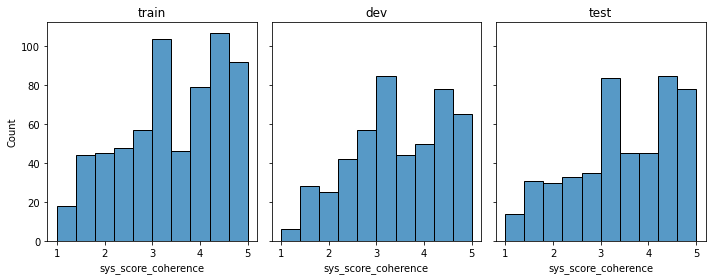

Scale!


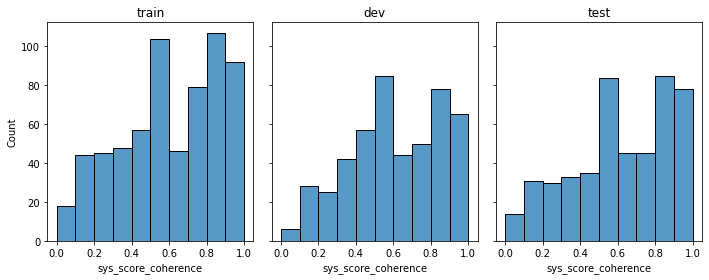

--------------------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
--------------------------------------------------------------------------------


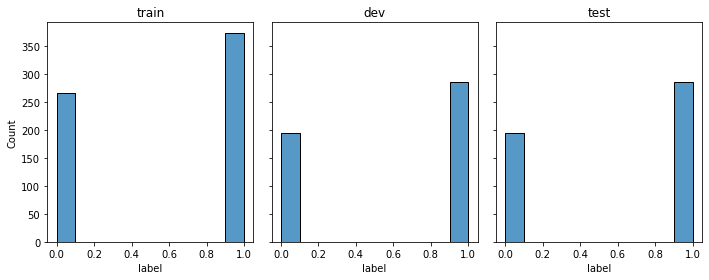

train
           index  sys_score_coherence
0  (-0.001, 0.5]             0.415625
1     (0.5, 1.0]             0.584375
dev
           index  sys_score_coherence
0  (-0.001, 0.5]             0.404167
1     (0.5, 1.0]             0.595833
test
           index  sys_score_coherence
0  (-0.001, 0.5]             0.404167
1     (0.5, 1.0]             0.595833
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


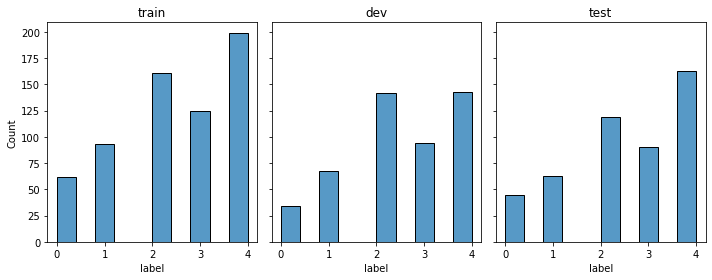

train
           index  sys_score_coherence
0  (-0.001, 0.2]             0.096875
1     (0.2, 0.4]             0.145313
2     (0.4, 0.6]             0.251563
3     (0.6, 0.8]             0.195312
4     (0.8, 1.0]             0.310937
dev
           index  sys_score_coherence
0  (-0.001, 0.2]             0.070833
1     (0.2, 0.4]             0.139583
2     (0.4, 0.6]             0.295833
3     (0.6, 0.8]             0.195833
4     (0.8, 1.0]             0.297917
test
           index  sys_score_coherence
0  (-0.001, 0.2]             0.093750
1     (0.2, 0.4]             0.131250
2     (0.4, 0.6]             0.247917
3     (0.6, 0.8]             0.187500
4     (0.8, 1.0]             0.339583


In [133]:
summeval_metadata_coh = summeval_metadata("coherence")
print(summeval_metadata_coh)

train_coh, dev_coh, test_coh = create_dataset(**summeval_metadata_coh)

### Relevance

{'dataset_name': 'SummEval', 'col': 'relevance', 'dev_fraction': 0.3, 'test_fraction': 0.3, 'seed': 498151, 'raw_dataset_dir': './data/summarization', 'output_dir': './data/summarization/SummEval_relevance/', 'scale': (1, 5)}
Loaded 100 examples.
Dataset SummEval train-dev-test split: 40 30 30
Train, dev, test set `sys_score_relevance` distribution


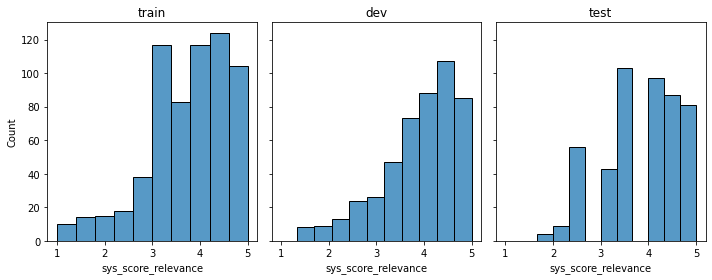

Scale!


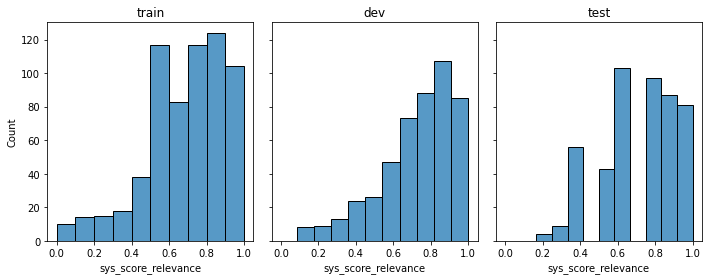

--------------------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
--------------------------------------------------------------------------------


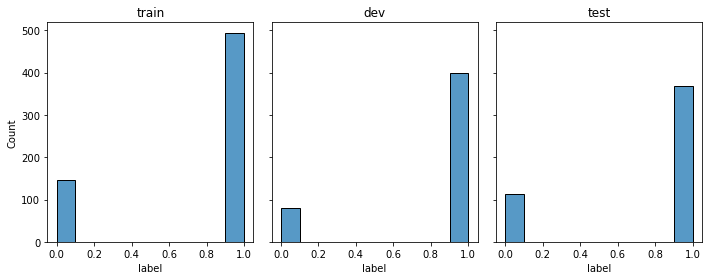

train
           index  sys_score_relevance
0  (-0.001, 0.5]             0.228125
1     (0.5, 1.0]             0.771875
dev
           index  sys_score_relevance
0  (-0.001, 0.5]             0.166667
1     (0.5, 1.0]             0.833333
test
           index  sys_score_relevance
0  (-0.001, 0.5]             0.233333
1     (0.5, 1.0]             0.766667
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


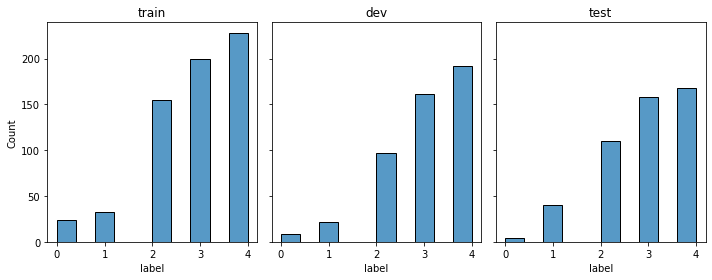

train
           index  sys_score_relevance
0  (-0.001, 0.2]             0.037500
1     (0.2, 0.4]             0.051562
2     (0.4, 0.6]             0.242188
3     (0.6, 0.8]             0.312500
4     (0.8, 1.0]             0.356250
dev
           index  sys_score_relevance
0  (-0.001, 0.2]             0.016667
1     (0.2, 0.4]             0.045833
2     (0.4, 0.6]             0.202083
3     (0.6, 0.8]             0.335417
4     (0.8, 1.0]             0.400000
test
           index  sys_score_relevance
0  (-0.001, 0.2]             0.008333
1     (0.2, 0.4]             0.083333
2     (0.4, 0.6]             0.229167
3     (0.6, 0.8]             0.329167
4     (0.8, 1.0]             0.350000


In [134]:
summeval_metadata_rel = summeval_metadata("relevance")
print(summeval_metadata_rel)

train_rel, dev_rel, test_rel = create_dataset(**summeval_metadata_rel)

### Consistency

{'dataset_name': 'SummEval', 'col': 'consistency', 'dev_fraction': 0.3, 'test_fraction': 0.3, 'seed': 498151, 'raw_dataset_dir': './data/summarization', 'output_dir': './data/summarization/SummEval_consistency/', 'scale': (1, 5)}
Loaded 100 examples.
Dataset SummEval train-dev-test split: 40 30 30
Train, dev, test set `sys_score_consistency` distribution


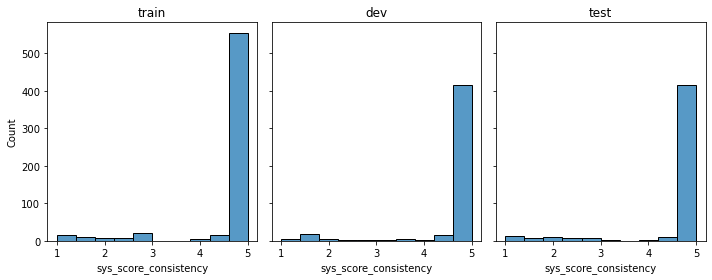

Scale!


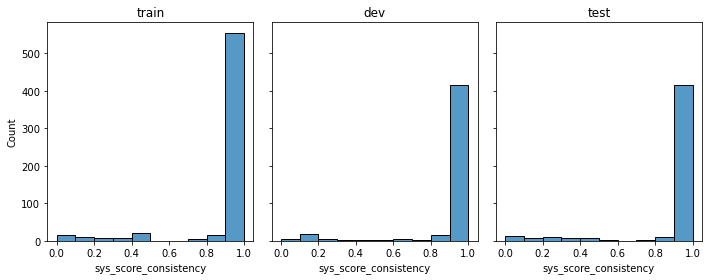

--------------------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
--------------------------------------------------------------------------------


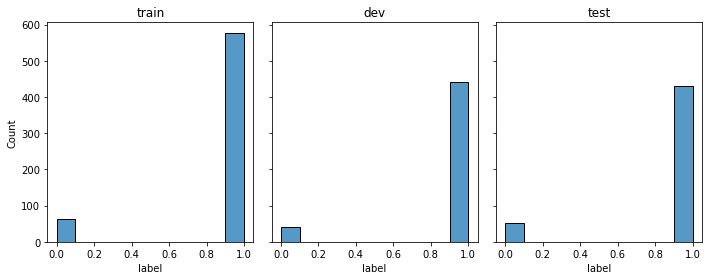

train
           index  sys_score_consistency
0  (-0.001, 0.5]               0.098437
1     (0.5, 1.0]               0.901563
dev
           index  sys_score_consistency
0  (-0.001, 0.5]               0.083333
1     (0.5, 1.0]               0.916667
test
           index  sys_score_consistency
0  (-0.001, 0.5]                0.10625
1     (0.5, 1.0]                0.89375
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


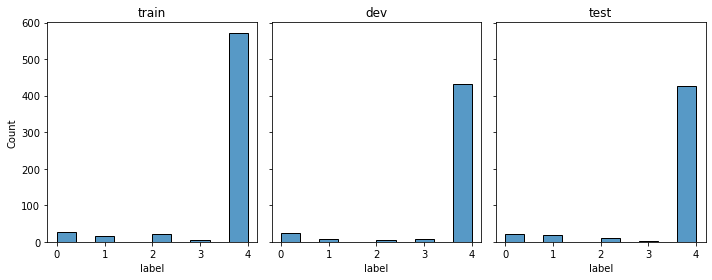

train
           index  sys_score_consistency
0  (-0.001, 0.2]               0.042188
1     (0.2, 0.4]               0.023438
2     (0.4, 0.6]               0.032813
3     (0.6, 0.8]               0.007812
4     (0.8, 1.0]               0.893750
dev
           index  sys_score_consistency
0  (-0.001, 0.2]               0.052083
1     (0.2, 0.4]               0.018750
2     (0.4, 0.6]               0.012500
3     (0.6, 0.8]               0.014583
4     (0.8, 1.0]               0.902083
test
           index  sys_score_consistency
0  (-0.001, 0.2]               0.045833
1     (0.2, 0.4]               0.039583
2     (0.4, 0.6]               0.020833
3     (0.6, 0.8]               0.006250
4     (0.8, 1.0]               0.887500


In [135]:
summeval_metadata_con = summeval_metadata("consistency")
print(summeval_metadata_con)

train_con, dev_con, test_con = create_dataset(**summeval_metadata_con)

### Fluency

{'dataset_name': 'SummEval', 'col': 'fluency', 'dev_fraction': 0.3, 'test_fraction': 0.3, 'seed': 498151, 'raw_dataset_dir': './data/summarization', 'output_dir': './data/summarization/SummEval_fluency/', 'scale': (1, 5)}
Loaded 100 examples.
Dataset SummEval train-dev-test split: 40 30 30
Train, dev, test set `sys_score_fluency` distribution


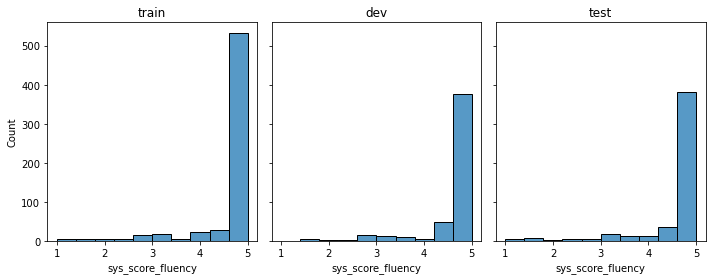

Scale!


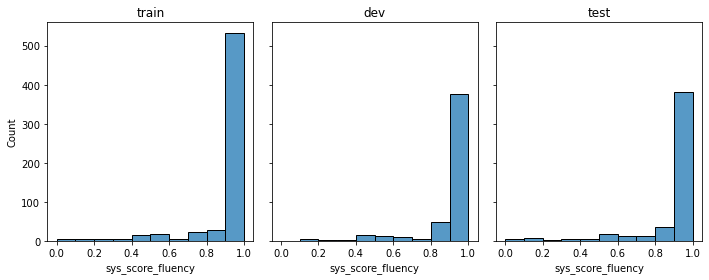

--------------------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
--------------------------------------------------------------------------------


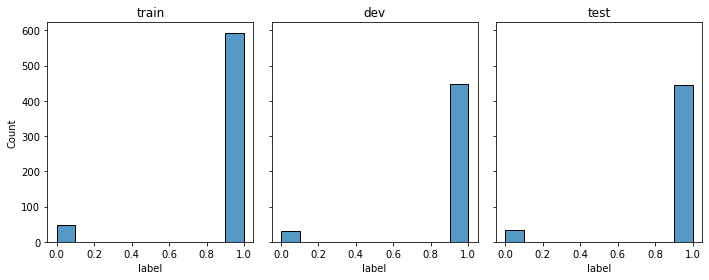

train
           index  sys_score_fluency
0  (-0.001, 0.5]           0.073438
1     (0.5, 1.0]           0.926562
dev
           index  sys_score_fluency
0  (-0.001, 0.5]           0.066667
1     (0.5, 1.0]           0.933333
test
           index  sys_score_fluency
0  (-0.001, 0.5]           0.070833
1     (0.5, 1.0]           0.929167
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


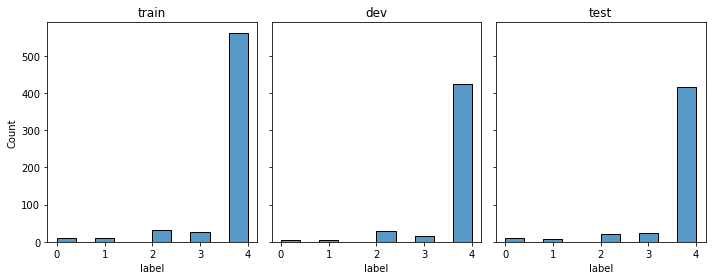

train
           index  sys_score_fluency
0  (-0.001, 0.2]           0.017188
1     (0.2, 0.4]           0.014063
2     (0.4, 0.6]           0.050000
3     (0.6, 0.8]           0.040625
4     (0.8, 1.0]           0.878125
dev
           index  sys_score_fluency
0  (-0.001, 0.2]           0.010417
1     (0.2, 0.4]           0.012500
2     (0.4, 0.6]           0.058333
3     (0.6, 0.8]           0.033333
4     (0.8, 1.0]           0.885417
test
           index  sys_score_fluency
0  (-0.001, 0.2]           0.022917
1     (0.2, 0.4]           0.014583
2     (0.4, 0.6]           0.045833
3     (0.6, 0.8]           0.050000
4     (0.8, 1.0]           0.866667


In [136]:
summeval_metadata_flu = summeval_metadata("fluency")
print(summeval_metadata_flu)

train_flu, dev_flu, test_flu = create_dataset(**summeval_metadata_flu)

## NewsRoom 18

In [140]:
ner_metadata = lambda col: {
    "dataset_name": "Newsroom",
    "col": col,
    "dev_fraction": 0.30,
    "test_fraction": 0.30,
    "seed": 498151,
    "raw_dataset_dir": "./data/summarization",
    "output_dir": f"./data/summarization/NeR18_{col}/",
    "scale": (1, 5),
}

# 'coherence': 2.66, 
# 'fluency': 3.33,
# 'informativeness': 2.67,
# 'relevance': 3.0

{'dataset_name': 'Newsroom', 'col': 'fluency', 'dev_fraction': 0.3, 'test_fraction': 0.3, 'seed': 498151, 'raw_dataset_dir': './data/summarization', 'output_dir': './data/summarization/NeR18_fluency/', 'scale': (1, 5)}
Loaded 60 examples.
Dataset Newsroom train-dev-test split: 24 18 18
Train, dev, test set `sys_score_fluency` distribution


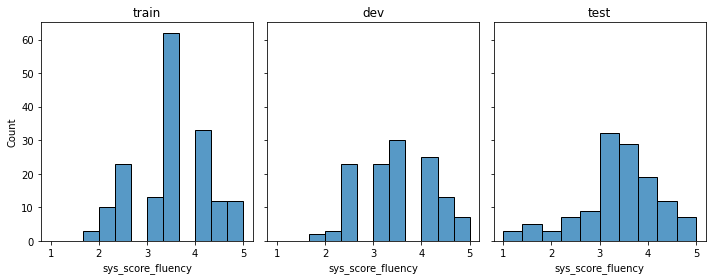

Scale!


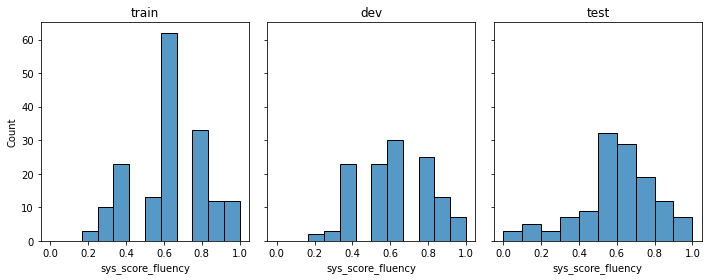

--------------------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
--------------------------------------------------------------------------------


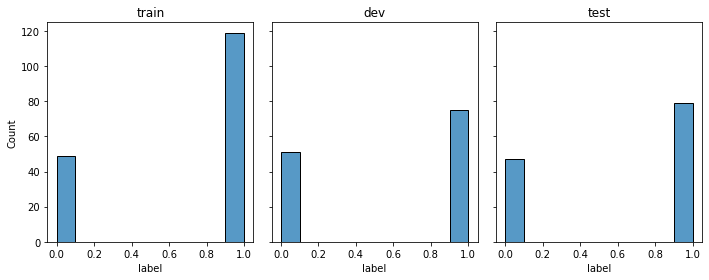

train
           index  sys_score_fluency
0  (-0.001, 0.5]           0.291667
1     (0.5, 1.0]           0.708333
dev
           index  sys_score_fluency
0  (-0.001, 0.5]           0.404762
1     (0.5, 1.0]           0.595238
test
           index  sys_score_fluency
0  (-0.001, 0.5]           0.373016
1     (0.5, 1.0]           0.626984
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


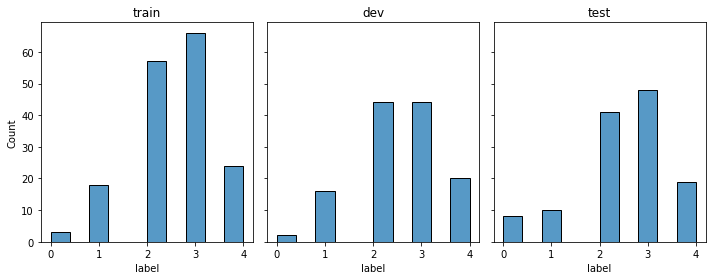

train
           index  sys_score_fluency
0  (-0.001, 0.2]           0.017857
1     (0.2, 0.4]           0.107143
2     (0.4, 0.6]           0.339286
3     (0.6, 0.8]           0.392857
4     (0.8, 1.0]           0.142857
dev
           index  sys_score_fluency
0  (-0.001, 0.2]           0.015873
1     (0.2, 0.4]           0.126984
2     (0.4, 0.6]           0.349206
3     (0.6, 0.8]           0.349206
4     (0.8, 1.0]           0.158730
test
           index  sys_score_fluency
0  (-0.001, 0.2]           0.063492
1     (0.2, 0.4]           0.079365
2     (0.4, 0.6]           0.325397
3     (0.6, 0.8]           0.380952
4     (0.8, 1.0]           0.150794


In [141]:
ner_metadata_flu = ner_metadata("fluency")
print(ner_metadata_flu)

train_flu, dev_flu, test_flu = create_dataset(**ner_metadata_flu)

{'dataset_name': 'Newsroom', 'col': 'coherence', 'dev_fraction': 0.3, 'test_fraction': 0.3, 'seed': 498151, 'raw_dataset_dir': './data/summarization', 'output_dir': './data/summarization/NeR18_coherence/', 'scale': (1, 5)}
Loaded 60 examples.
Dataset Newsroom train-dev-test split: 24 18 18
Train, dev, test set `sys_score_coherence` distribution


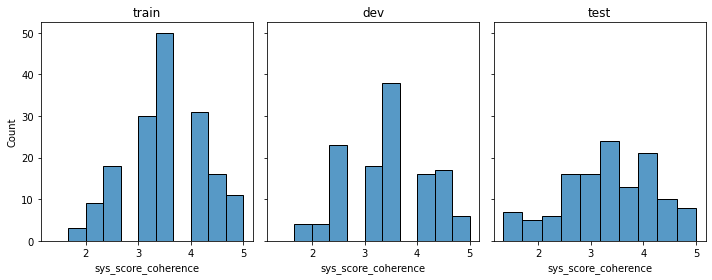

Scale!


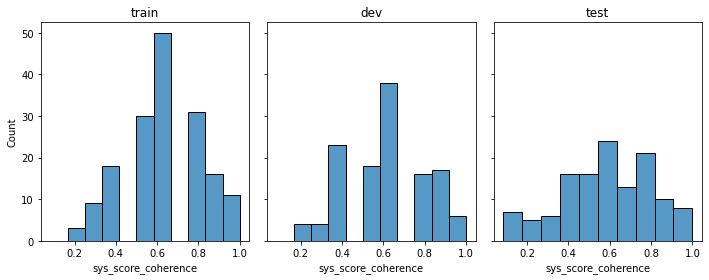

--------------------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
--------------------------------------------------------------------------------


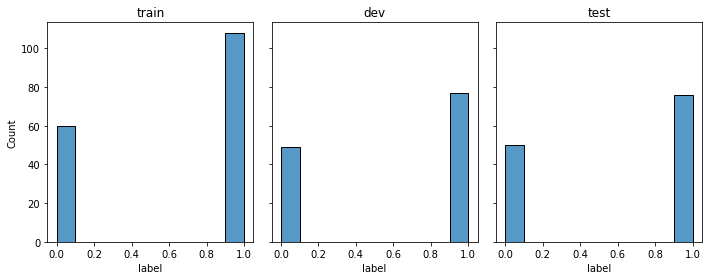

train
           index  sys_score_coherence
0  (-0.001, 0.5]             0.357143
1     (0.5, 1.0]             0.642857
dev
           index  sys_score_coherence
0  (-0.001, 0.5]             0.388889
1     (0.5, 1.0]             0.611111
test
           index  sys_score_coherence
0  (-0.001, 0.5]             0.396825
1     (0.5, 1.0]             0.603175
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


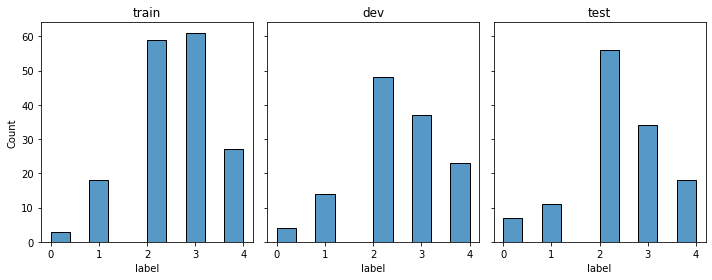

train
           index  sys_score_coherence
0  (-0.001, 0.2]             0.017857
1     (0.2, 0.4]             0.107143
2     (0.4, 0.6]             0.351190
3     (0.6, 0.8]             0.363095
4     (0.8, 1.0]             0.160714
dev
           index  sys_score_coherence
0  (-0.001, 0.2]             0.031746
1     (0.2, 0.4]             0.111111
2     (0.4, 0.6]             0.380952
3     (0.6, 0.8]             0.293651
4     (0.8, 1.0]             0.182540
test
           index  sys_score_coherence
0  (-0.001, 0.2]             0.055556
1     (0.2, 0.4]             0.087302
2     (0.4, 0.6]             0.444444
3     (0.6, 0.8]             0.269841
4     (0.8, 1.0]             0.142857


In [142]:
ner_metadata_coh = ner_metadata("coherence")
print(ner_metadata_coh)

train_coh, dev_coh, test_coh = create_dataset(**ner_metadata_coh)

{'dataset_name': 'Newsroom', 'col': 'relevance', 'dev_fraction': 0.3, 'test_fraction': 0.3, 'seed': 498151, 'raw_dataset_dir': './data/summarization', 'output_dir': './data/summarization/NeR18_relevance/', 'scale': (1, 5)}
Loaded 60 examples.
Dataset Newsroom train-dev-test split: 24 18 18
Train, dev, test set `sys_score_relevance` distribution


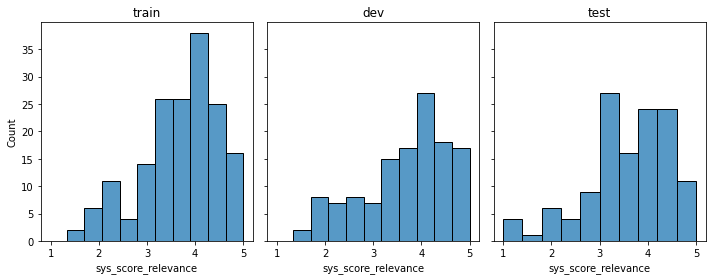

Scale!


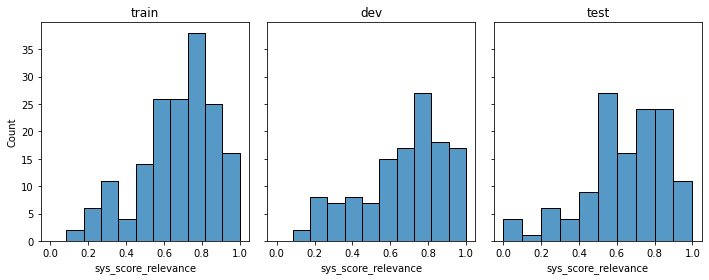

--------------------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
--------------------------------------------------------------------------------


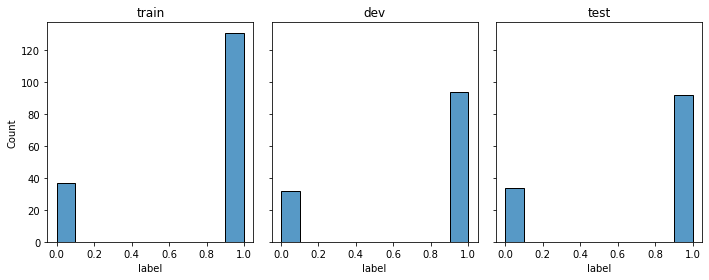

train
           index  sys_score_relevance
0  (-0.001, 0.5]             0.220238
1     (0.5, 1.0]             0.779762
dev
           index  sys_score_relevance
0  (-0.001, 0.5]             0.253968
1     (0.5, 1.0]             0.746032
test
           index  sys_score_relevance
0  (-0.001, 0.5]             0.269841
1     (0.5, 1.0]             0.730159
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


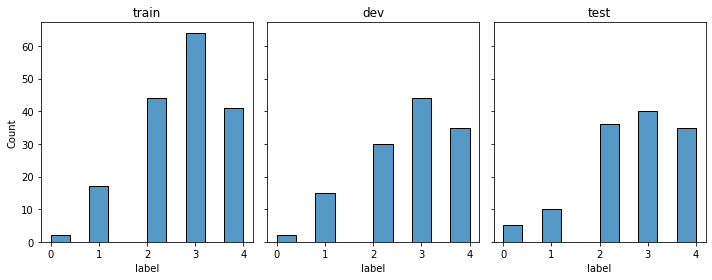

train
           index  sys_score_relevance
0  (-0.001, 0.2]             0.011905
1     (0.2, 0.4]             0.101190
2     (0.4, 0.6]             0.261905
3     (0.6, 0.8]             0.380952
4     (0.8, 1.0]             0.244048
dev
           index  sys_score_relevance
0  (-0.001, 0.2]             0.015873
1     (0.2, 0.4]             0.119048
2     (0.4, 0.6]             0.238095
3     (0.6, 0.8]             0.349206
4     (0.8, 1.0]             0.277778
test
           index  sys_score_relevance
0  (-0.001, 0.2]             0.039683
1     (0.2, 0.4]             0.079365
2     (0.4, 0.6]             0.285714
3     (0.6, 0.8]             0.317460
4     (0.8, 1.0]             0.277778


In [143]:
ner_metadata_rel = ner_metadata("relevance")
print(ner_metadata_rel)

train_rel, dev_rel, test_rel = create_dataset(**ner_metadata_rel)

{'dataset_name': 'Newsroom', 'col': 'informativeness', 'dev_fraction': 0.3, 'test_fraction': 0.3, 'seed': 498151, 'raw_dataset_dir': './data/summarization', 'output_dir': './data/summarization/NeR18_informativeness/', 'scale': (1, 5)}
Loaded 60 examples.
Dataset Newsroom train-dev-test split: 24 18 18
Train, dev, test set `sys_score_informativeness` distribution


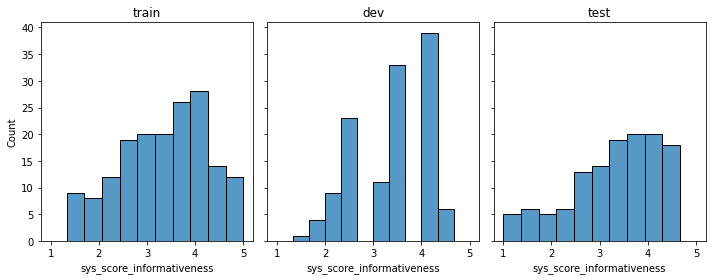

Scale!


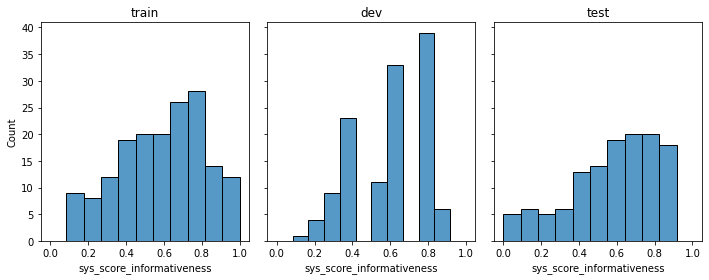

--------------------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
--------------------------------------------------------------------------------


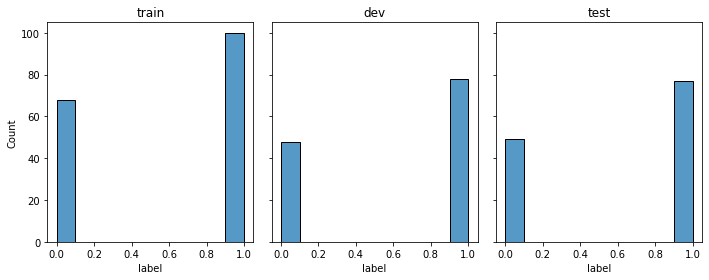

train
           index  sys_score_informativeness
0  (-0.001, 0.5]                   0.404762
1     (0.5, 1.0]                   0.595238
dev
           index  sys_score_informativeness
0  (-0.001, 0.5]                   0.380952
1     (0.5, 1.0]                   0.619048
test
           index  sys_score_informativeness
0  (-0.001, 0.5]                   0.388889
1     (0.5, 1.0]                   0.611111
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


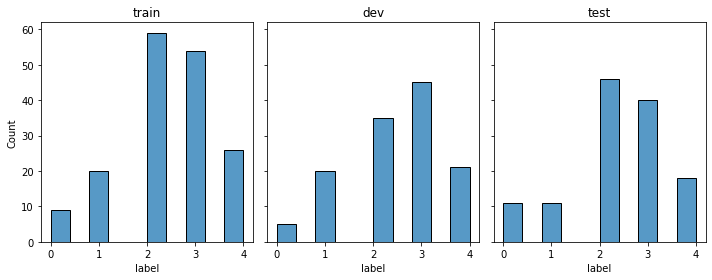

train
           index  sys_score_informativeness
0  (-0.001, 0.2]                   0.053571
1     (0.2, 0.4]                   0.119048
2     (0.4, 0.6]                   0.351190
3     (0.6, 0.8]                   0.321429
4     (0.8, 1.0]                   0.154762
dev
           index  sys_score_informativeness
0  (-0.001, 0.2]                   0.039683
1     (0.2, 0.4]                   0.158730
2     (0.4, 0.6]                   0.277778
3     (0.6, 0.8]                   0.357143
4     (0.8, 1.0]                   0.166667
test
           index  sys_score_informativeness
0  (-0.001, 0.2]                   0.087302
1     (0.2, 0.4]                   0.087302
2     (0.4, 0.6]                   0.365079
3     (0.6, 0.8]                   0.317460
4     (0.8, 1.0]                   0.142857


In [144]:
ner_metadata_info = ner_metadata("informativeness")
print(ner_metadata_info)

train_info, dev_info, test_info = create_dataset(**ner_metadata_info)

## Summarization Factuality Datasets

### Rank18 (needs cross-reference --- only has relative comparison 0/1 fact scores)

In [146]:
joblib.load("./data/summarization/QAGS_CNN_data_raw.pkl")

{0: {'src': "Vitamin and mineral supplements are becoming more and more popular as health conscious shoppers focus on good nutrition , but do we really need pills to optimise our diet ? Not according to nutritionist and author sarah flower , who says that cooking with the right ingredients should give you all the goodness you need . ` the cleaner your diet - using fresh ingredients and cooking at home - the less likely you are to need to rely on supplements to boost your health . ' She told mailonline . Scroll down for video . It 's time to ditch vitamin pills for a diet rich in clean , fresh and unprocessed foods , says sarah flower . ` the typical western diet is heavily processed and sugar ridden , ' explains sarah , ` this makes us more susceptible to vitamin and mineral deficiencies . ' And while it may seem like common sense to eat more unprocessed and raw foods , ms flower believes we are still not doing enough . ` we are living in a society where it is possible to be overweight

### QAGS

Loaded 235 examples.
Dataset QAGS_CNN train-dev-test split: 95 70 70
Train, dev, test set `sys_score_fact` distribution


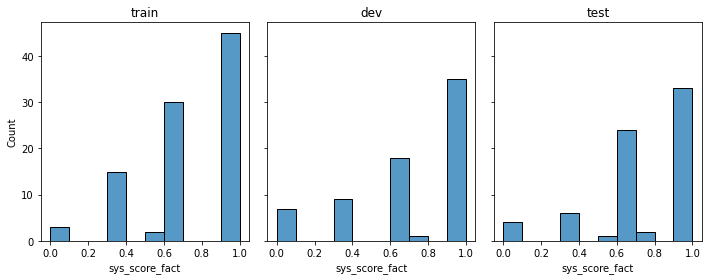

--------------------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
--------------------------------------------------------------------------------


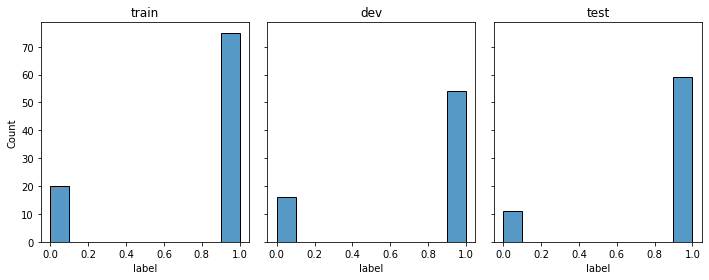

train
           index  sys_score_fact
0  (-0.001, 0.5]        0.210526
1     (0.5, 1.0]        0.789474
dev
           index  sys_score_fact
0  (-0.001, 0.5]        0.228571
1     (0.5, 1.0]        0.771429
test
           index  sys_score_fact
0  (-0.001, 0.5]        0.157143
1     (0.5, 1.0]        0.842857
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


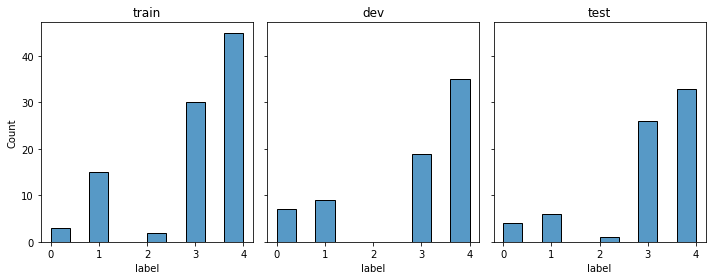

train
           index  sys_score_fact
0  (-0.001, 0.2]        0.031579
1     (0.2, 0.4]        0.157895
2     (0.4, 0.6]        0.021053
3     (0.6, 0.8]        0.315789
4     (0.8, 1.0]        0.473684
dev
           index  sys_score_fact
0  (-0.001, 0.2]        0.100000
1     (0.2, 0.4]        0.128571
2     (0.4, 0.6]        0.000000
3     (0.6, 0.8]        0.271429
4     (0.8, 1.0]        0.500000
test
           index  sys_score_fact
0  (-0.001, 0.2]        0.057143
1     (0.2, 0.4]        0.085714
2     (0.4, 0.6]        0.014286
3     (0.6, 0.8]        0.371429
4     (0.8, 1.0]        0.471429


[    index  bartscore_doc_id  \
 0       0                 1   
 1       1                 2   
 2       2                 5   
 3       3                11   
 4       4                12   
 ..    ...               ...   
 90     90               224   
 91     91               227   
 92     92               228   
 93     93               229   
 94     94               232   
 
                                                   src  \
 0   England will send an under 20 team to the toul...   
 1   A southern iowa chiropractor accused of accept...   
 2   Cooking a gourmet lunch for family and friends...   
 3   Parents have been outraged to discover a herit...   
 4   The parents of a student who vanished in myste...   
 ..                                                ...   
 90  Robbie fowler is already among the names of th...   
 91  A mysterious easter bunny has delivered chocol...   
 92  Tony blair has said he does not want to retire...   
 93  Since it was revealed that an

In [147]:
qags_cnn_metadata = {
    "dataset_name": "QAGS_CNN",
    "col": "fact",
    "dev_fraction": 0.30,
    "test_fraction": 0.30,
    "seed": 498151,
    "raw_dataset_dir": "./data/summarization",
    "output_dir": "./data/summarization/QAGS_CNN",
}

create_dataset(**qags_cnn_metadata);

### QAGS-XSUM (binary only) (?)

Loaded 239 examples.
Dataset QAGS_XSUM train-dev-test split: 95 72 72
Train, dev, test set `sys_score_fact` distribution


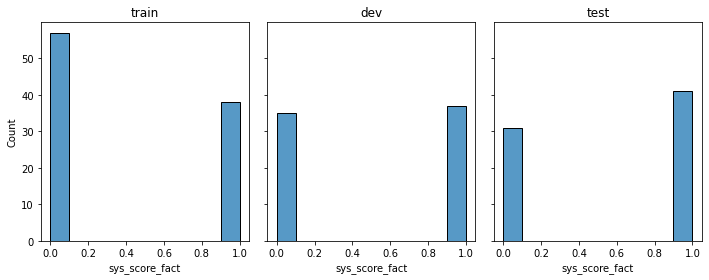

--------------------------------------------------------------------------------
2-class distribution using configs: {'binrange': (0, 1), 'bins': 2}
--------------------------------------------------------------------------------


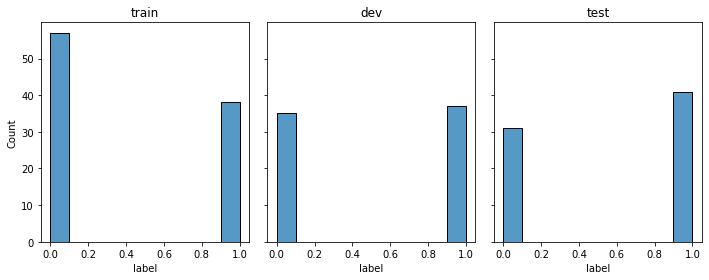

train
           index  sys_score_fact
0  (-0.001, 0.5]             0.6
1     (0.5, 1.0]             0.4
dev
           index  sys_score_fact
0  (-0.001, 0.5]        0.486111
1     (0.5, 1.0]        0.513889
test
           index  sys_score_fact
0  (-0.001, 0.5]        0.430556
1     (0.5, 1.0]        0.569444
--------------------------------------------------------------------------------
5-Class distribution using configs: {'binrange': (0, 1), 'bins': 5}
--------------------------------------------------------------------------------


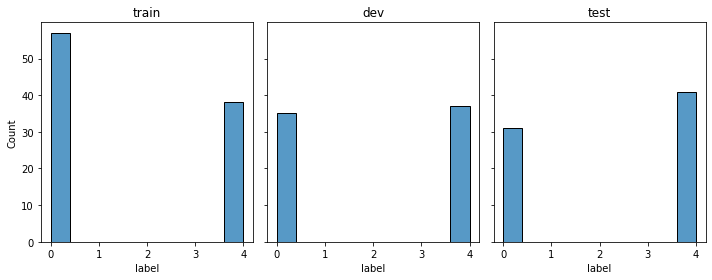

train
           index  sys_score_fact
0  (-0.001, 0.2]             0.6
1     (0.2, 0.4]             0.0
2     (0.4, 0.6]             0.0
3     (0.6, 0.8]             0.0
4     (0.8, 1.0]             0.4
dev
           index  sys_score_fact
0  (-0.001, 0.2]        0.486111
1     (0.2, 0.4]        0.000000
2     (0.4, 0.6]        0.000000
3     (0.6, 0.8]        0.000000
4     (0.8, 1.0]        0.513889
test
           index  sys_score_fact
0  (-0.001, 0.2]        0.430556
1     (0.2, 0.4]        0.000000
2     (0.4, 0.6]        0.000000
3     (0.6, 0.8]        0.000000
4     (0.8, 1.0]        0.569444


In [148]:
qags_cnn_metadata = {
    "dataset_name": "QAGS_XSUM",
    "col": "fact",
    "dev_fraction": 0.30,
    "test_fraction": 0.30,
    "seed": 498151,
    "raw_dataset_dir": "./data/summarization",
    "output_dir": "./data/summarization/QAGS_XSUM",
}

create_dataset(**qags_cnn_metadata);

In [151]:
joblib.load("./data/summarization/QAGS_XSUM_data_raw.pkl")[20]

{'src': "Thailand 's military-run government has forced human rights watch ( hrw ) to cancel an event in bangkok to launch a report into alleged abuses in vietnam . Thai officials said the event , which was halted minutes before it was due to start , could have affected relations between the two countries . The hrw report focuses on the treatment of a christian group in vietnam . The group said the thai response showed how freedom of speech had been eroded since the army seized power last year . Thai police said the event at the foreign correspondents club of thailand could `` have an impact on the country 's security or could affect the friendship and cooperation between thailand and vietnam '' . It is the third human rights event at the venue that has been halted by authorities in the past month . The hrw report describes what it says is the persecution of montagnard christians in vietnam 's central highlands . Their religious practices have been described by the vietnamese governmen